# Assignment 2: Spatial Models - Networks

### Aleksandar Jacimovic, id: 15278247,  Kevin Schaaf 11058668

In [3]:
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import ndlib
import ndlib.models.epidemics as ep
import os
import pandas as pd
import scipy
from scipy.integrate import odeint     
from scipy.optimize import minimize
import statsmodels as sm
import sympy as sp

## Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks

The following code incorporates # Gillespie's Direct Algorithm as well as the standard deterministic model.

First, we write a function to solve the differential equations corresponding to the SIR model with demography and where SIRN = the current state-variable, t = time, beta = transmission rate, gamma = recovery rate, mu = birth and death rate

In [118]:
def my_ode_11(SIRN, t, beta, gamma, mu):
    S, I, R, N = SIRN
    dSdt = mu*N -beta*S*I/N - mu*S
    dIdt = beta*S*I/N - gamma*I - mu*I
    dRdt = gamma*I - mu*R
    return [dSdt, dIdt, dRdt, 0]

Next, we set the parameters and conditions

In [4]:
beta_11 = 1.8
gamma_11 = 0.1
mu_11 = 0.02
N = 10000 #Size of the population

X_0 = 0.8*N
Y_0 = 0.2*N
Z_0 = 0

SIRN0_11 = [X_0, Y_0, Z_0, N] # Make sure that these elements are integers since they represent the number of persons in that category. 

t_0 = 0
t_final = 100
t = np.linspace(t_0, t_final, 100)

In [5]:
solution_11 = odeint(my_ode_11, SIRN0_11, t, args=(beta_11, gamma_11, mu_11))
S_solution_11, I_solution_11, R_solution_11, N_solution_11 = solution_11.T

Gillespie's Direct Algorithm: box 6.3 on page 201 of the KR book

In [6]:
#step 1: label all possible events
events = ['births', 'transmission', 'recovery', 'death_in_S', 'death_in_I', 'death_in_R']       
# counter = 0  #counts the number of events that have occured
time = [0]
X = [0.8*N]
Y = [0.2*N]
Z = [0*N]

while time[-1] < t_final:
    current_X = X[-1]
    current_Y = Y[-1]
    current_Z = Z[-1]
    current_time = time[-1]
    #step 2: determine the rate at which each event occurs
    event_rates = np.array([mu_11*N, 
                            beta_11*current_X*current_Y/N, 
                            gamma_11*current_Y, 
                            mu_11*current_X, 
                            mu_11*current_Y, 
                            mu_11*current_Z])
    #step 3: the rate at which any event occurs
    rate_sum = np.sum(event_rates) 
    #step 4: the time until the next event
    delta_t = -1/rate_sum * np.log(1-np.random.uniform(0,1))  
    #step 5: generate a new random number
    p = np.random.uniform(0,1) * rate_sum                                                      
    time.append(current_time + delta_t)  
    
    if current_Y == 0 and Y[-2] != 0:
        print(f'extinction at time = {time[-1]}')                                                  
    if 0 <= p and p <= np.sum(event_rates[:1]):
        X.append(current_X + 1)
        Y.append(current_Y)
        Z.append(current_Z)
    elif np.sum(event_rates[:1]) < p and p <= np.sum(event_rates[:2]):
        Y.append(current_Y + 1)
        X.append(current_X - 1)
        Z.append(current_Z)
    elif np.sum(event_rates[:2]) < p and p <= np.sum(event_rates[:3]):
        X.append(current_X)
        Y.append(current_Y - 1)
        Z.append(current_Z + 1)
    elif np.sum(event_rates[:3]) < p and p <= np.sum(event_rates[:4]):
        X.append(current_X - 1)
        Y.append(current_Y)
        Z.append(current_Z)
    elif np.sum(event_rates[:4]) < p and p <= np.sum(event_rates[:5]):
        X.append(current_X)
        Y.append(current_Y - 1)
        Z.append(current_Z)
    elif np.sum(event_rates[:5]) < p and p <= np.sum(event_rates[:6]):
        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z - 1)        

In [7]:
# define colors
blues = ['blue', '#6699FF']  # standard blue and light blue 
reds = ['red', '#FF6666']    # standard red and light red 
greens = ['green', '#90EE90']  # standard yellow and light yellow 

In [ ]:
plt.figure(figsize=(10, 6))

# stochastic (darker)
plt.plot(time, X, label='S', color = blues[0])
plt.plot(time, Y, label='I', color = reds[0])
plt.plot(time, Z, label='R', color = greens[0])

# deterministic (lighter)
plt.plot(t, S_solution_11, color = blues[1])
plt.plot(t, I_solution_11, color = reds[1])
plt.plot(t, R_solution_11, color = greens[1])

plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title(fr'SIR Development over Time. $\beta$={beta_11}, $\gamma$={gamma_11}, $\mu$={mu_11}, $R_0$ = {beta_11/(gamma_11+mu_11)}, N={N}, {chr(10)} stochastic outcomes given in darker shades')
plt.legend()
plt.grid()
plt.show()

The deterministic model relatively quickly reaches the equillibrium. Meanwhile, in a stochastic model that convergence to lower values of indfectious individual could take longer. Additionally, due to death and birth rates, the susceptible pool can grow and the recovered pool can decrease - potentially leading to new spikes in the epidemic. 

The code incorporates the time determination if an extinction occures. Once an extintion is printed, another epidemic would not be possible. 

### Experiment 1: Variability and Covariance

In the next section we investigate the influence of varying the model parameters (beta, gamma and mu) on the stochastic behaviour of the model. We are particularly interested in the variance between runs and the covariance between S and I within runs. We will also be comparing the mean of the stochastic simulations with the deterministic output. 

In [9]:
def gillespie_sir(beta, gamma, mu, N, max_time):
    S = N - 1
    I = 1
    R = 0
    t = 0
    S_data, I_data, R_data, time_data = [S], [I], [R], [t]

    while t < max_time and I > 0:
        #step 2: determine the rate at which each event occurs
        rate_birth = mu * N
        rate_transmission = beta * S * I / N
        rate_recovery = gamma * I
        rate_death_in_S = mu * S
        rate_death_in_I = mu * I
        rate_death_in_R = mu * R
        #step 3: the rate at which any event occurs
        rates_sum = (rate_birth + rate_transmission + rate_recovery +
                     rate_death_in_S + rate_death_in_I + rate_death_in_R)
        #step 4: the time until the next event
        t += -np.log(np.random.random()) / rates_sum # -1/rate_sum * np.log(1-np.random.uniform(0,1))  
        #step 5: generate a new random number
        rand = np.random.random() * rates_sum
        # step 6: occurence of event p 
        if rand < rate_birth:
            S += 1
        elif rand < rate_birth + rate_transmission:
            S -= 1
            I += 1
        elif rand < rate_birth + rate_transmission + rate_recovery:
            I -= 1
            R += 1
        elif rand < rate_birth + rate_transmission + rate_recovery + rate_death_in_S:
            S -= 1
        elif rand < rate_birth + rate_transmission + rate_recovery + rate_death_in_S + rate_death_in_I:
            I -= 1
        else:
            R -= 1

        S_data.append(S)
        I_data.append(I)
        R_data.append(R)
        time_data.append(t)

    return np.array(S_data), np.array(I_data), np.array(R_data), np.array(time_data)


In [10]:
# set up parameter ranges
beta_values = np.linspace(0.1, 3.0, 50)  # infection rate
gamma_values = np.linspace(0.1, 1.0, 20)  # recovery rate
mu_values = np.linspace(0.01, 0.1, 10)  # birth/death rate
iterations = 10  # number of iterations per parameter combination
N = 1000  # total population
max_time = 200  # maximum simulation time

In [11]:
# collect statistics for each parameter combination
time_series_data_deterministic = []
time_series_data_stochastic = []
results = []

for beta in beta_values:
    for gamma in gamma_values:
        for mu in mu_values:
            
            X_0 = N-1
            Y_0 = 1
            Z_0 = 0
            SIRN_0 = [X_0, Y_0, Z_0, N] 
            
            t = np.linspace(0, max_time, max_time)
            
            det_solution = odeint(my_ode_11, SIRN_0, t, args=(beta, gamma, mu))    
            S_solution, I_solution, R_solution, N_solution = det_solution.T
            
            # make sure the data arrays are all of the length max_time
            len_diff = max_time - len(S_solution)
            if len_diff > 0:
               # extend the arrays if too short
                S_solution = np.pad(S_solution, (0, len_diff), 'constant', constant_values=(S_solution[-1],))
                I_solution = np.pad(I_solution, (0, len_diff), 'constant', constant_values=(I_solution[-1],))
                R_solution = np.pad(R_solution, (0, len_diff), 'constant', constant_values=(R_solution[-1],))
            elif len_diff < 0:
                # cut if they too long
                S_solution = S_solution[:max_time]
                I_solution = I_solution[:max_time]
                R_solution = R_solution[:max_time]
            
            S_agg = np.zeros(max_time)
            I_agg = np.zeros(max_time)
            R_agg = np.zeros(max_time)
            
            variance_S = []
            std_S = []
            variance_I = []
            std_I = []
            covariances_SI = []
            
            for iteration in range(iterations):
                S_data, I_data, R_data, time_data = gillespie_sir(beta, gamma, mu, N, max_time)
                
                # make sure the data arrays are all of the length max_time
                len_diff = max_time - len(S_data)
                if len_diff > 0:
                    # extend the arrays if too short
                    S_data = np.pad(S_data, (0, len_diff), 'constant', constant_values=(S_data[-1],))
                    I_data = np.pad(I_data, (0, len_diff), 'constant', constant_values=(I_data[-1],))
                    R_data = np.pad(R_data, (0, len_diff), 'constant', constant_values=(R_data[-1],))
                    time_data = np.pad(time_data, (0, len_diff), 'constant', constant_values=(time_data[-1],))
                elif len_diff < 0:
                    # cut if they too long
                    S_data = S_data[:max_time]
                    I_data = I_data[:max_time]
                    R_data = R_data[:max_time]
                    time_data = time_data[:max_time]

                S_agg += S_data
                I_agg += I_data
                R_agg += R_data
                
                variance_S.append(np.var(S_data))
                std_S.append(np.std(S_data))
                variance_I.append(np.var(I_data))
                std_I.append(np.std(I_data))
                covariances_SI.append(np.cov(S_data, I_data)[0, 1])
            
            # calculate means
            S_mean = S_agg / iterations
            I_mean = I_agg / iterations
            R_mean = R_agg / iterations
            
            # append to the list
            time_series_data_deterministic.append({
                'beta': beta,
                'gamma': gamma,
                'mu': mu,
                'S_solution': S_solution,
                'I_solution': I_solution,
                'R_solution': R_solution,
                'time': time_data
            })
            
            time_series_data_stochastic.append({
                'beta': beta,
                'gamma': gamma,
                'mu': mu,
                'S_mean': S_mean,
                'I_mean': I_mean,
                'R_mean': R_mean,
                'time': time_data
            })
            
            # calculate variable means across parameter iterations
            mean_variance_S = np.mean(variance_S)
            mean_std_S = np.mean(std_S)
            mean_variance_I = np.mean(variance_I)
            mean_std_I = np.mean(std_I)
            mean_covariance_SI = np.mean(covariances_SI)
            # results
            results.append({
                'beta': beta,
                'gamma': gamma,
                'mu': mu,
                'mean_variance_S': mean_variance_S, 
                'mean_std_S': mean_std_S, 
                'mean_variance_I': mean_variance_I, 
                'mean_std_I': mean_std_I, 
                'mean_covariance_SI': mean_covariance_SI
            })

In [12]:
# convert the results to a df
df_deterministic = pd.DataFrame(time_series_data_deterministic)
df_stochastic = pd.DataFrame(time_series_data_stochastic)
df_results = pd.DataFrame(results)

# calculate R0s
df_results['R0'] = df_results['beta'] / (df_results['gamma'] + df_results['mu'])

In [ ]:
display(df_deterministic)

In [ ]:
display(df_stochastic)

Find the parameters with the best and the worst fits between the deterministic and mean stochastic outcome

In [18]:
from sklearn.metrics import mean_squared_error

In [37]:
det_t = df_deterministic[(df_deterministic['beta'] == beta) & 
                         (df_deterministic['gamma'] == gamma) & 
                         (df_deterministic['mu'] == mu)]
stoch_t = df_stochastic[(df_stochastic['beta'] == beta) & 
                        (df_stochastic['gamma'] == gamma) & 
                        (df_stochastic['mu'] == mu)]

In [ ]:
display(det_t)

In [ ]:
display(stoch_t)

In [19]:
# compute the MSE for each parameter set
for item in results:
    beta = item['beta']
    gamma = item['gamma']
    mu = item['mu']
    
    # filter the deterministic and stochastic data for the current set of parameters
    det = df_deterministic[(df_deterministic['beta'] == beta) & 
                           (df_deterministic['gamma'] == gamma) & 
                           (df_deterministic['mu'] == mu)]
    stoch = df_stochastic[(df_stochastic['beta'] == beta) & 
                          (df_stochastic['gamma'] == gamma) & 
                          (df_stochastic['mu'] == mu)]
    
    # compute MSE for S and I between deterministic and stochastic models
    mse_S = mean_squared_error(det['S_solution'].values[0], stoch['S_mean'].values[0])
    mse_I = mean_squared_error(det['I_solution'].values[0], stoch['I_mean'].values[0])
    
    # update the results dictionary with the MSE values
    item['mse_S'] = mse_S
    item['mse_I'] = mse_I

In [ ]:
# sort the results by the sum of mse_S and mse_I to find the lowest and highest MSE
results_sorted = sorted(results, key=lambda x: (x['mse_S'] + x['mse_I']))
lowest_mse = results_sorted[0]
highest_mse = results_sorted[-1]

In [67]:
df_results_updated = pd.DataFrame(results)
# calculate R0s
df_results_updated['R0'] = df_results_updated['beta'] / (df_results_updated['gamma'] + df_results_updated['mu'])
df_results_updated['MSE_sum'] = df_results_updated['mse_S']+df_results_updated['mse_I']

In [ ]:
display(df_results_updated)

In [ ]:
# calculate the max value of R_0 considered across all parametrisations 
max(df_results_updated['R0'])

#### Plotting

In [ ]:
# divergence between S and I for various values of beta based on the sum of MSE(S) and MSE(I)
plt.figure(figsize=(10, 8))
df_beta = df_results_updated.groupby('beta')['MSE_sum'].mean().reset_index()
plt.plot(df_beta['beta'], df_beta['MSE_sum'], marker='o')
plt.xlabel('Infection Rate')
plt.ylabel(fr'Sum of Mean Square Errors (MSE) {chr(10)} between Average Stochastic and Deterministic Outcomes')
plt.title(fr'MSE(I)+MSE(S) vs $\beta$')
plt.grid(True)
plt.show()

In [ ]:
# divergence between S and I for various values of gamma based on the sum of MSE(S) and MSE(I)
plt.figure(figsize=(10, 8))
df_gamma = df_results_updated.groupby('gamma')['MSE_sum'].mean().reset_index()
plt.plot(df_gamma['gamma'], df_gamma['MSE_sum'], marker='o')
plt.xlabel('Recovery Rate')
plt.ylabel(fr'Sum of Mean Square Errors (MSE) {chr(10)} between Average Stochastic and Deterministic Outcomes')
plt.title(fr'MSE(I)+MSE(S) vs $\gamma$')
plt.grid(True)
plt.show()

In [ ]:
# divergence between S and I for various values of mu based on the sum of MSE(S) and MSE(I)
plt.figure(figsize=(10, 8))
df_mu = df_results_updated.groupby('mu')['MSE_sum'].mean().reset_index()
plt.plot(df_mu['mu'], df_mu['MSE_sum'], marker='o')
plt.xlabel('Birth / Death Rate')
plt.ylabel(fr'Sum of Mean Square Errors (MSE) {chr(10)} between Average Stochastic and Deterministic Outcomes')
plt.title(fr'MSE(I)+MSE(S) vs $\mu$')
plt.grid(True)
plt.show()

In [84]:
# plot the comparison cases between stochastic and deterministic 
def plot_sir_comparison(det, stoch, title):
    min_length = min(len(det['time']), len(stoch['time']))
    time = det['time'][:min_length]
    S_det = det['S_solution'][:min_length]
    I_det = det['I_solution'][:min_length]
    R_det = det['R_solution'][:min_length]
    S_stoch = stoch['S_mean'][:min_length]
    I_stoch = stoch['I_mean'][:min_length]
    R_stoch = stoch['R_mean'][:min_length]
    
    plt.figure(figsize=(12, 6))

    # deterministic data
    plt.plot(time, S_det, label='S (Deterministic)', color= blues[1])
    plt.plot(time, I_det, label='I (Deterministic)', color= reds[1])
    plt.plot(time, R_det, label='R (Deterministic)', color= greens[1])

    # stochastic data
    plt.plot(time, S_stoch, label='S (Stochastic)', linestyle='--', color= blues[0])
    plt.plot(time, I_stoch, label='I (Stochastic)', linestyle='--', color= reds[0])
    plt.plot(time, R_stoch, label='R (Stochastic)', linestyle='--', color= greens[0])

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend(loc='center right')
    plt.grid(True)
    plt.show()

In [ ]:
# Plot for the lowest MSE
det_lowest = df_deterministic[(df_deterministic['beta'] == lowest_mse['beta']) & 
                              (df_deterministic['gamma'] == lowest_mse['gamma']) & 
                              (df_deterministic['mu'] == lowest_mse['mu'])].iloc[0]
stoch_lowest = df_stochastic[(df_stochastic['beta'] == lowest_mse['beta']) & 
                             (df_stochastic['gamma'] == lowest_mse['gamma']) & 
                             (df_stochastic['mu'] == lowest_mse['mu'])].iloc[0]
plot_sir_comparison(det_lowest, stoch_lowest, 'SIR Model - Deterministic vs. Stochastic (Lowest MSE)')

# Plot for the highest MSE
det_highest = df_deterministic[(df_deterministic['beta'] == highest_mse['beta']) & 
                               (df_deterministic['gamma'] == highest_mse['gamma']) & 
                               (df_deterministic['mu'] == highest_mse['mu'])].iloc[0]
stoch_highest = df_stochastic[(df_stochastic['beta'] == highest_mse['beta']) & 
                               (df_stochastic['gamma'] == highest_mse['gamma']) & 
                               (df_stochastic['mu'] == highest_mse['mu'])].iloc[0]

plot_sir_comparison(det_highest, stoch_highest, 'SIR Model - Deterministic vs. Stochastic (Highest MSE)')

In [ ]:
# parameter set generating the highest MSE sum 
print(highest_mse['beta'],highest_mse['gamma'],highest_mse['mu'])

In [ ]:
# parameter set generating the lowest MSE sum 
print(round(lowest_mse['beta'],2),round(lowest_mse['gamma'],2), round(lowest_mse['mu'],2))

In [ ]:
# mean variance in I for various values of R_0
plt.figure(figsize=(10, 8))
df_R0 = df_results.groupby('R0')['mean_variance_I'].mean().reset_index()
plt.plot(df_R0['R0'], df_R0['mean_variance_I'], marker='o')
plt.xlabel(fr'Basic Reproduction Number ($R_0$)')
plt.ylabel('Mean Variance in I')
plt.title(fr'Mean Variance in I vs $R_0$')
plt.grid(True)
plt.show()

In [ ]:
# mean covariance between S and I for various values of R_0
plt.figure(figsize=(10, 8))
df_R0 = df_results.groupby('R0')['mean_covariance_SI'].mean().reset_index()
plt.plot(df_R0['R0'], df_R0['mean_covariance_SI'], marker='o')
plt.xlabel(fr'Basic Reproduction Number ($R_0$)')
plt.ylabel('Mean Covariance between S and I')
plt.title(fr'Mean Covariance between S and I vs $R_0$')
plt.grid(True)
plt.show()

In [ ]:
# mean variance in I for each value of beta
plt.figure(figsize=(10, 8))
df_beta = df_results.groupby('beta')['mean_variance_I'].mean().reset_index()
plt.plot(df_beta['beta'], df_beta['mean_variance_I'], marker='o')
plt.xlabel(fr'Infection Rate ($\beta$)')
plt.ylabel('Mean Variance in I')
plt.title(fr'Mean Variance in I vs $\beta$')
plt.grid(True)
plt.show()

In [ ]:
# mean covariance between S and I for each value of beta
plt.figure(figsize=(10, 8))
df_beta = df_results.groupby('beta')['mean_covariance_SI'].mean().reset_index()
plt.plot(df_beta['beta'], df_beta['mean_covariance_SI'], marker='o')
plt.xlabel(fr'Infection Rate ($\beta$)')
plt.ylabel('Mean Covariance between S and I')
plt.title(fr'Mean Covariance between S and I vs $\beta$')
plt.grid(True)
plt.show()

In [ ]:
# mean variance in I for each value of gamma
plt.figure(figsize=(10, 8))
df_gamma = df_results.groupby('gamma')['mean_variance_I'].mean().reset_index()
plt.plot(df_gamma['gamma'], df_gamma['mean_variance_I'], marker='o')
plt.xlabel(fr'Recovery Rate ($\gamma$)')
plt.ylabel('Mean Variance in I')
plt.title(fr'Mean Variance in I vs $\gamma$')
plt.grid(True)
plt.show()

In [ ]:
# mean covariance between S and I for each value of gamma
plt.figure(figsize=(10, 8))
df_gamma = df_results.groupby('gamma')['mean_covariance_SI'].mean().reset_index()
plt.plot(df_gamma['gamma'], df_gamma['mean_covariance_SI'], marker='o')
plt.xlabel(fr'Recovery Rate ($\gamma$)')
plt.ylabel('Mean Covariance between S and I')
plt.title(fr'Mean Covariance vs $\gamma$')
plt.grid(True)
plt.show()

In [ ]:
# mean variance in I for each value of mu
plt.figure(figsize=(10, 8))
df_mu = df_results.groupby('mu')['mean_variance_I'].mean().reset_index()
plt.plot(df_mu['mu'], df_mu['mean_variance_I'], marker='o')
plt.xlabel(fr'Birth/Death Rate ($\mu$)')
plt.ylabel('Mean Variance in I')
plt.title(fr'Mean Variance in I vs $\mu$')
plt.grid(True)
plt.show()

In [ ]:
# mean covariance between S and I for each value of mu
plt.figure(figsize=(10, 8))
df_mu = df_results.groupby('mu')['mean_covariance_SI'].mean().reset_index()
plt.plot(df_mu['mu'], df_mu['mean_covariance_SI'], marker='o')
plt.xlabel(fr'Birth/Death Rate ($\mu$)')
plt.ylabel('Mean Covariance between S and I')
plt.title(fr'Mean Covariance vs $\mu$')
plt.grid(True)
plt.show()

Alternative (old) implementation of the algorithm 

In [ ]:
N = 10000 # population size 
X_0 = 0.8*N
Y_0 = 0.2*N
Z_0 = 0

SIRN0_12 = [X_0, Y_0, Z_0, N] # should have integer values

t_0 = 0
t_final = 100
t = np.linspace(t_0, t_final, 100)

In [ ]:
counter = 1
runs = 10

# store data for all runs in a list
reference = [1,50,99]

for i in range(2):
    beta_12 = 0.8 * (i + 1)
    for j in range(2):
        gamma_12 = 0.3 * (j + 1)
        for k in range(2):
            storage_X1 = []
            storage_Y1 = []
            storage_Z1 = []
            
            storage_X50 = []
            storage_Y50 = []
            storage_Z50 = []
            
            storage_X99 = []
            storage_Y99 = []
            storage_Z99 = []
            
            storage_covariance =[]
            
            mean_X1 = []
            var_X1 = []
            
            mean_Y1 = []
            var_Y1 = []
            
            mean_Z1 = []
            var_Z1 = []
            
            mean_X50 = []
            var_X50 = []
            
            mean_Y50 = []
            var_Y50 = []
            
            mean_Z50 = []
            var_Z50 = []
            
            mean_X99 = []
            var_X99 = []
            
            mean_Y99 = []
            var_Y99 = []
            
            mean_Z99 = []
            var_Z99 = []
            
            mu_12 = 0.01 * (k + 1)
            solution_12 = odeint(my_ode_11, SIRN0_12, t, args=(beta_12, gamma_12, mu_12))
            S_solution_12, I_solution_12, R_solution_12, N_solution_12 = solution_12.T
            extinction = False
            
            for m in range(runs):
                time = [0]
                X = [0.8 * N]
                Y = [0.2 * N]
                Z = [0]
                while time[-1] < t_final:
                    event_rates = np.array([mu_12 * N, beta_12 * X[-1] * Y[-1] / N, 
                                            gamma_12 * Y[-1], 
                                            mu_12 * X[-1], 
                                            mu_12 * Y[-1], 
                                            mu_12 * Z[-1]])
                    rate_sum = np.sum(event_rates)
                    delta_t = -1 / rate_sum * np.log(1 - np.random.uniform(0, 1))
                    p = np.random.uniform(0, 1) * rate_sum
                    time.append(time[-1] + delta_t)
                    if 0 < p and p <= np.sum(event_rates[:1]):
                        X.append(X[-1] + 1)
                        Y.append(Y[-1])
                        Z.append(Z[-1])
                    elif np.sum(event_rates[:1]) < p and p <= np.sum(event_rates[:2]):
                        X.append(X[-1] - 1)
                        Y.append(Y[-1] + 1)
                        Z.append(Z[-1])
                    elif np.sum(event_rates[:2]) < p and p <= np.sum(event_rates[:3]):
                        X.append(X[-1])
                        Y.append(Y[-1] - 1)
                        Z.append(Z[-1] + 1)
                    elif np.sum(event_rates[:3]) < p and p <= np.sum(event_rates[:4]):
                        X.append(X[-1] - 1)
                        Y.append(Y[-1])
                        Z.append(Z[-1])
                    elif np.sum(event_rates[:4]) < p and p <= np.sum(event_rates[:5]):
                        X.append(X[-1])
                        Y.append(Y[-1] - 1)
                        Z.append(Z[-1])
                    elif np.sum(event_rates[:5]) < p and p <= np.sum(event_rates[:6]):
                        X.append(X[-1])
                        Y.append(Y[-1])
                        Z.append(Z[-1] - 1)
                    # Save the values of x,y and z around timepoints 1, 50 and 99. 
                    if time[-2]< 1 and time[-1]>= 1:
                        storage_X1.append(X[-1])
                        storage_Y1.append(Y[-1])
                        storage_Z1.append(Z[-1])
                    if time[-2]< 50 and time[-1]>= 50:
                        storage_X50.append(X[-1])
                        storage_Y50.append(Y[-1])
                        storage_Z50.append(Z[-1])
                    if time[-2]< 99 and time[-1]>= 99:
                        storage_X99.append(X[-1])
                        storage_Y99.append(Y[-1])
                        storage_Z99.append(Z[-1])
                        
                #calculation of covariance between number of susceptibles and number of infectious 
                covariance_matrix = np.cov(X, Y)
                covariance = covariance_matrix[0,1]
                print(covariance)
                storage_covariance.append(covariance)
                
            mean_X1 = np.mean(storage_X1)
            var_X1 = np.std(storage_X1)
            
            mean_Y1 = np.mean(storage_Y1)
            var_Y1 = np.std(storage_Y1)
            
            mean_Z1 = np.mean(storage_Z1)
            var_Z1 = np.std(storage_Z1)
            
            mean_X50 = np.mean(storage_X50)
            var_X50 = np.std(storage_X50)            
            
            mean_Y50 = np.mean(storage_Y50)
            var_Y50 = np.std(storage_Y50)            
            
            mean_Z50 = np.mean(storage_Z50)
            var_Z50 = np.std(storage_Z50)            
            
            mean_X99 = np.mean(storage_X99)
            var_X99 = np.std(storage_X99)            
            
            mean_Y99 = np.mean(storage_Y99)
            var_Y99 = np.std(storage_Y99)            
            
            mean_Z99 = np.mean(storage_Z99)
            var_Z99 = np.std(storage_Z99)
            
            plt.figure(figsize=(8, 6))
            plt.scatter(reference, [mean_X1, mean_X50, mean_X99], color='yellow')
            plt.errorbar(reference, [mean_X1, mean_X50, mean_X99], yerr=[var_X1, var_X50, var_X99], fmt='o', color='yellow')
            plt.scatter(reference, [mean_Y1, mean_Y50, mean_Y99], color='blue')
            plt.errorbar(reference, [mean_Y1, mean_Y50, mean_Y99], yerr=[var_Y1, var_Y50, var_Y99], fmt='o', color='blue')
            plt.scatter(reference, [mean_Z1, mean_Z50, mean_Z99], color='red')
            plt.errorbar(reference, [mean_Z1, mean_Z50, mean_Z99], yerr=[var_Z1, var_Z50, var_Z99], fmt='o', color='red')
            plt.plot(t, S_solution_12, label='S', color='yellow')
            plt.plot(t, I_solution_12, label='I', color='blue')
            plt.plot(t, R_solution_12, label='R', color='red')
            plt.xlabel('time')
            plt.legend()
            plt.ylabel('Number of people')
            plt.title(fr'Figure 1.2.{counter}: Development of SIR in Time. $\beta$={beta_12}, $\gamma$={gamma_12}, $\mu$={mu_12}, R_0 = {round(beta_12/(gamma_12+mu_12),2)}, N={N} {chr(10)} The mean covariance with these parameter conditions is {np.mean(storage_covariance)}')
            plt.grid()
            plt.show()
            counter += 1

Depending on the parameter values, the trend points obtained from stochastic outcomes at times 1, 50 and 99 can be well aligned to the deterministic outcomes, but can also deviate (both in case when the average covariance between S and I is positive and when it is negative). 

### Experiment 2: Stochastic Resonance and Transients

Start by running the deterministic method to equilibrium and then evaluate the stochastic outcomes around the same section. 

In [119]:
N = 1000                    # population size
X_0 = 0.8*N                  # initial number of susceptibles
Y_0 = 0.2*N                  # initial number of infectious 
Z_0 = 0                      # initial number of recovered
SIRN0_13 = [X_0, Y_0, Z_0, N]   # initial state

t0 = 0                      
t_final = 100

t1 = np.linspace(t0, t_final*10, 1000)      # for the ode to approxiamate equilibrium-values of the system with the given set of parameter values
t = np.linspace(t0, t_final, 100)           # for the ode to be a reference for the stochastic simulation.
counter = 1                                 # ennumeration of the figures.

In [ ]:
for i in range(10):
    for j in range(10):
        for k in range(5):
            beta_13 = 0.8*(i+1)
            gamma_13 = 0.1*(j+1)
            mu_13 = 0.01*(k+1)
            solution_13 = odeint(my_ode_11, SIRN0_13, t1, args=(beta_13, gamma_13, mu_13))    
            S_solution_13, I_solution_13, R_solution_13, N_solution_13 = solution_13.T       
            #the last value set of these variables provides us with an approximation of the equilibrium point
           
            # Gillespie's Direct Algorithm: look at box 6.3 on page 201 of the KR book. 
            # step 1: label all possible events
            events = ['births', 'transmission', 'recovery', 'death_in_S', 'death_in_I', 'death_in_R']       
            
            time = [0]
            X = [S_solution_13[-1]]
            Y = [I_solution_13[-1]]
            Z = [R_solution_13[-1]]
            extinction = False
            
            while time[-1] < t_final:
                # step 2: determine the rate at which each event occurs
                event_rates = np.array([mu_13*N, beta_13*X[-1]*Y[-1]/N, gamma_13*Y[-1], 
                                        mu_13*X[-1], mu_13*Y[-1], mu_13*Z[-1]])            
                # step 3: the rate at which any event occurs
                rate_sum = np.sum(event_rates)               
                # step 4: the time until the next event
                delta_t = -1/rate_sum * np.log(1-np.random.uniform(0,1))       
                # step 5: generate a new random number
                p = np.random.uniform(0,1) * rate_sum     
                # step 6: adjust the time-variable     
                time.append(time[-1] + delta_t)                                                  
                if 0 <= p and p <= np.sum(event_rates[:1]):                                      
                    X.append(X[-1] + 1)
                    Y.append(Y[-1])
                    Z.append(Z[-1])
                elif np.sum(event_rates[:1]) < p and p <= np.sum(event_rates[:2]):
                    Y.append(Y[-1] + 1)
                    X.append(X[-1] - 1)
                    Z.append(Z[-1])
                elif np.sum(event_rates[:2]) < p and p <= np.sum(event_rates[:3]):
                    X.append(X[-1])
                    Y.append(Y[-1] - 1)
                    Z.append(Z[-1] + 1)
                elif np.sum(event_rates[:3]) < p and p <= np.sum(event_rates[:4]):
                    X.append(X[-1] - 1)
                    Y.append(Y[-1])
                    Z.append(Z[-1])
                elif np.sum(event_rates[:4]) < p and p <= np.sum(event_rates[:5]):
                    X.append(X[-1])
                    Y.append(Y[-1] - 1)
                    Z.append(Z[-1])
                elif np.sum(event_rates[:5]) < p and p <= np.sum(event_rates[:6]):
                    X.append(X[-1])
                    Y.append(Y[-1])
                    Z.append(Z[-1] - 1)        
                if Y[-1] == 0 and Y[-2] != 0:
                    extinction = True
                    print(f'extinction at time = {time[-1]}')
            solution_13 = odeint(my_ode_11, [S_solution_13[-1],I_solution_13[-1],R_solution_13[-1],N], t, args=(beta_13, gamma_13, mu_13))
            S_solution_13, I_solution_13, R_solution_13, N_solution_13 = solution_13.T
            if max(Y) - min(Y) > 100:
                
                plt.figure(figsize=(8, 6))
                plt.plot(time, X, label='S', color= blues[0])
                plt.plot(time, Y, label='I', color= reds[0])
                plt.plot(time, Z, label='R', color= greens[0])
                plt.plot(t, S_solution_13, color= blues[1])
                plt.plot(t, I_solution_13, color= reds[1])
                plt.plot(t, R_solution_13, color= greens[1])
                
                plt.xlabel('time')
                plt.ylabel('Number of people')
                plt.title(fr'Figure 1.3.{counter}: Development of SIR in Time. $\beta$={round(beta_13,2)}, $\gamma$={round(gamma_13,2)}, $\mu$={round(mu_13,2)}, R_0 = {round(round(beta_13,2)/(round(gamma_13,2)+round(mu_13,2)),2)}, N={N}')
                plt.legend(loc='center right')
                plt.grid()
                plt.show()
                counter += 1

### Experiment 3: Extinction Process and Critical Community Size

Now evaluate the link between the behavior of extinction rate and different values of $R_0$ and population sizes. 

In [ ]:
N0 = 1000 #Size of the population
t_final = 1000
runs = 10

In [ ]:
for i in range(4): #4 iterations of i will give populations of 10^3, 5*10^3, 10^4, 5*10^4, 10^5, 5*10^5 and 10^6
    N = N0*10**i
    for j in range(10):
        counter = 0
        for k in range(runs):
            gamma_14 = 0.1
            mu_14 = 0.02
            R_0 = 1+0.1*j
            beta_14 = R_0*(gamma_14+mu_14)
            
            # Gillespie's Direct Algorithm: box 6.3 on page 201 of the KR book. 
            # step 1: label all possible events
            events = ['births', 'transmission', 'recovery', 'death_in_S', 'death_in_I', 'death_in_R']       
            time = [0]
            X = [0.8*N]
            Y = [0.2*N]
            Z = [0]
            extinction = False
            while time[-1] < t_final:
                # step 2: determine the rate at which each event occurs
                event_rates = np.array([mu_13*N, beta_13*X[-1]*Y[-1]/N, gamma_13*Y[-1], mu_13*X[-1], mu_13*Y[-1], mu_13*Z[-1]]) 
                # step 3: the rate at which any event occurs
                rate_sum = np.sum(event_rates)      
                # step 4: the time until the next event
                delta_t = -1/rate_sum * np.log(1-np.random.uniform(0,1))   
                # step 5: generate a new random number
                p = np.random.uniform(0,1) * rate_sum                                                      
                time.append(time[-1] + delta_t)                                                        
                if 0 <= p and p <= np.sum(event_rates[:1]):
                    X.append(X[-1] + 1)
                    Y.append(Y[-1])
                    Z.append(Z[-1])
                elif np.sum(event_rates[:1]) < p and p <= np.sum(event_rates[:2]):
                    Y.append(Y[-1] + 1)
                    X.append(X[-1] - 1)
                    Z.append(Z[-1])
                elif np.sum(event_rates[:2]) < p and p <= np.sum(event_rates[:3]):
                    X.append(X[-1])
                    Y.append(Y[-1] - 1)
                    Z.append(Z[-1] + 1)
                elif np.sum(event_rates[:3]) < p and p <= np.sum(event_rates[:4]):
                    X.append(X[-1] - 1)
                    Y.append(Y[-1])
                    Z.append(Z[-1])
                elif np.sum(event_rates[:4]) < p and p <= np.sum(event_rates[:5]):
                    X.append(X[-1])
                    Y.append(Y[-1] - 1)
                    Z.append(Z[-1])
                elif np.sum(event_rates[:5]) < p and p <= np.sum(event_rates[:6]):
                    X.append(X[-1])
                    Y.append(Y[-1])
                    Z.append(Z[-1] - 1)        
                if Y[-2] > 0 and Y[-1] <= 0:
                    extinction = True
                    counter += 1
                    # print(f'extinction at time = {time[-1]} with R_0={R_0} and N={N}')
        print(f'With R_0={round(R_0,2)} and N={N}, {counter} out of {runs} runs resulted in extinction within {t_final} days.')

## Problem 2:  Spatial Models - Networks

Start by reading the SocioPatterns data file 

In [124]:
path= "/Users/aleksandar/Desktop/Computational Science MSc/Introduction to Computational Science/Assignements/assignment_2_2023_oct_5/"
os.chdir(path)
# Hello

In [ ]:
# the path to the folder containing the csv file
folder_path = 'data/'

# the name of the csv file you want to read
file_name = 'transmission_network.csv'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

# read the csv file into a data frame
try:
    df = pd.read_csv(file_path, sep = ";")
    print(df.head())
except FileNotFoundError:
    print(f"The file '{file_name}' was not found in the folder '{folder_path}'.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

In [ ]:
df = df.rename(columns={df.columns[0]:'nodes'})
display(df)

the network adjacency matrix is given with the 'nodes' column and the other col names giving the opposite node indicatiors

Following the guidance in the assignment, we disregard the weights and assume all contacts involve equal length of contact and hence equal chance of transmission. Hence, we convert the adjacency matrix above into the one where all weights are equal to 1. 

In [ ]:
# change all non-zero values from the second column onwards to 1
df.iloc[:, 1:] = (df.iloc[:, 1:] != 0).astype(int)

display(df)

## Problem 2.1: 

Implement SIR disease spread on the sociopattern network. Think about your experimental design and which parameters of the model you will want to vary. Design code that will allow you run multiple simulations while varying the disease parameter

### Set Up

Test create an ER graph object

In [128]:
g_er = nx.erdos_renyi_graph(1000, 0.1)

Create a graph object using the SocioPatterns adjacency matrix

In [13]:
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import ndlib
import ndlib.models.epidemics as ep
import os
import pandas as pd
import scipy
from scipy.integrate import odeint     
from scipy.optimize import minimize
import statsmodels as sm
import sympy as sp
import json

In [2]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

# create a graph object
g = nx.Graph()

# extract node names from the first column of the dataframe
nodes = df['nodes'].tolist()
# add nodes to the graph
g.add_nodes_from(nodes)

In [ ]:
num_nodes = g.number_of_nodes()
print(num_nodes)

In [ ]:
print(nodes)
print(len(nodes))

In [5]:
# iterate through the dataframe and add edges
for index, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            target_node = int(col_name)
            g.add_edge(source_node, target_node)

In [ ]:
nodes_list = list(g.nodes())
print(nodes_list)

In [ ]:
# create a layout for the nodes
pos = nx.kamada_kawai_layout(g)

# draw the nodes and edges
nx.draw(g, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(g, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

add a relabled version of the graph - where existing nodes are labled in an order

In [42]:
mapping = {node: i for i, node in enumerate(g.nodes())}
g_re = nx.relabel_nodes(g, mapping)

In [ ]:
print(g_re.nodes())

### Model Selection and Configuration

Set up SIR model configurations using the code on the NDlib reference page

Import epidemics from ndlib and set up the SIR model object

In [44]:
model = ep.SIRModel(g_re)

Use json to obtain parameters of the model

In [ ]:
print(json.dumps(model.parameters, indent=2))

Display available model statuses

In [ ]:
model.available_statuses

Specify a model configuration by setting model parameter values

In [47]:
import ndlib.models.ModelConfig as mc

In [48]:
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.02) #infection rate
cfg.add_model_parameter('gamma', 0.01) #recovery rate 
# + 
cfg.add_model_parameter("percentage_infected", 0.01)
model.set_initial_status(cfg)

As described in the reference notebook, NDlib models diffusive phenomena as discrete-time, agent-based processes, where during every iteration all nodes are evaluated and, their statuses are updated accoridng to the model rules. 

We use iterations to generate model outcome instances, across all nodes. 

In [49]:
iterations = model.iteration_bunch(200, node_status = True)

We use build_trends to transform iterations into diffusion trends

In [50]:
trends = model.build_trends(iterations)

In [ ]:
print(type(trends[0]['trends']))

In [ ]:
print(trends[0]['trends']['node_count'][0])

#### Visualise using DiffusionTrend and DiffusionPrevalence 

Diffusion trend in the SIR spread on the network

In [ ]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

viz = DiffusionTrend(model, trends)
viz.plot() 

# assuming the last created figure and axes are the ones from DiffusionTrend
#fig, ax = plt.gcf(), plt.gca()  # Get current figure and axes

# customize
#ax.set_title(fr'Figure: SIR Spread on the SocioPatterns Network')
#ax.set_xlabel('Iterations')
#ax.set_ylabel('Fraction of Nodes')
#ax.legend()
#ax.grid()

#plt.show()
#counter += 1


Diffusion prevalence in the SIR spread on the network

In [ ]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence (model, trends)
viz.plot()

Set the parameter range values

In [25]:
beta_values = np.linspace(0.1, 3, 101)
gamma_values = np.linspace(0.01, 1, 101)
percentage_infected = 0.01

In [26]:
r0_values = []

for beta in beta_values: 
    for gamma in gamma_values: 
        r0 = beta/gamma
        r0_values.append(r0)

In [ ]:
# R0 histogram
plt.figure(figsize=(10, 6))

plt.hist(r0_values, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of R0 values obtained for variations of beta and gamma parameters')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Initiate variables to store results of each run in

generate model outcomes (101x101)

In [67]:
# Generate SIR model object
SIR_model = ep.SIRModel(g)

# Set parameter values
betas = np.linspace(0.1, 3, 101)
gammas = np.linspace(0.01, 1, 101)
percentage_infected = 0.01
nr_iterations = 200

# Pre-allocate variables.
all_I = []
S_store = np.zeros((len(betas), len(gammas), nr_iterations))
I_store = np.zeros((len(betas), len(gammas), nr_iterations))
R_store = np.zeros((len(betas), len(gammas), nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)

for beta_ix, beta in enumerate(betas):
    for gamma_ix, gamma in enumerate(gammas):
        # (Re)set every node as susceptible
        for node in g.nodes():
            SIR_model.status[node] = 0
            
        # Set model configurations
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        SIR_model.set_initial_status(cfg)
        iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
        trends = SIR_model.build_trends(iterations)
        
        # Extract values based on updated structure
        node_counts = trends[0]['trends']['node_count']
        S = node_counts[0]
        I = node_counts[1]
        R = node_counts[2]
        
        # Storing all I for the plot of all realizations
        all_I.append(I)

        # Store the sums for averages
        S_store[beta_ix, gamma_ix] = S
        I_store[beta_ix, gamma_ix] = I
        R_store[beta_ix, gamma_ix] = R
        

S_mean = (np.mean(np.mean(S_store, axis=0), axis=0))
I_mean = (np.mean(np.mean(I_store, axis=0), axis=0))
R_mean = (np.mean(np.mean(R_store, axis=0), axis=0))

In [68]:
print(len(all_I), len(I_mean))

10201 200


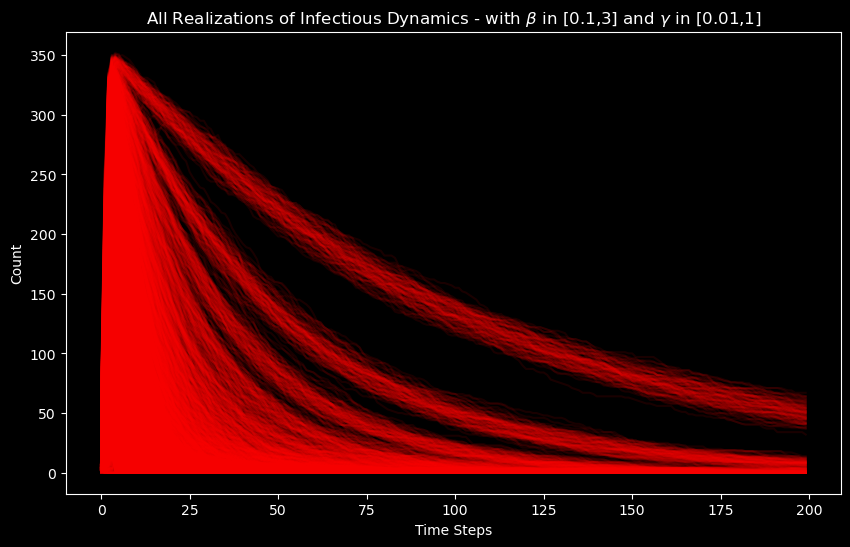

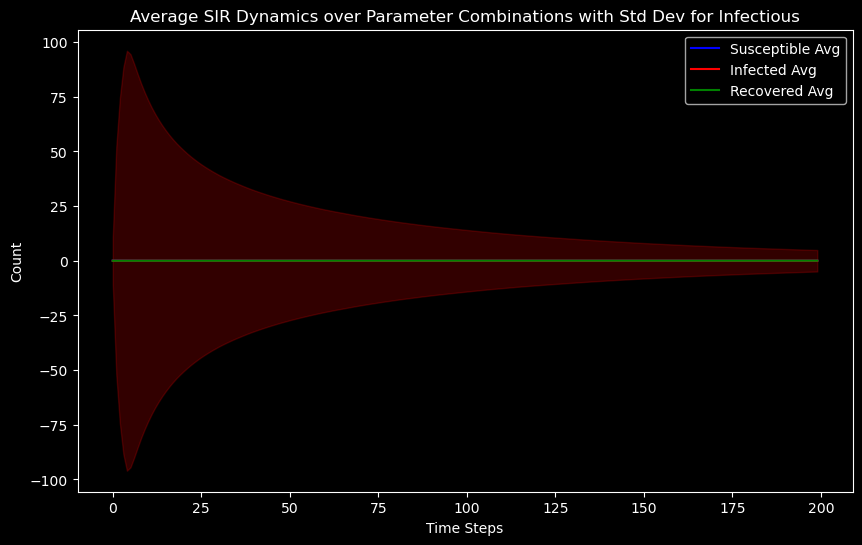

In [69]:
# Plot of all the realizations
plt.figure(figsize=(10, 6))
for I in all_I:
    plt.plot(I, color='red', alpha=0.1)  # alpha for transparency
plt.title(r'All Realizations of Infectious Dynamics - with $\beta$ in [0.1,3] and $\gamma$ in [0.01,1]')
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.show()

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(avg_S, label="Susceptible Avg", color='blue')
plt.fill_between(range(len(avg_I)), 
                 [i - s for i, s in zip(avg_I, std_I)], 
                 [i + s for i, s in zip(avg_I, std_I)], 
                 color='red', alpha=0.2)
plt.plot(avg_I, label="Infected Avg", color='red')
plt.plot(avg_R, label="Recovered Avg", color='green')
plt.title("Average SIR Dynamics over Parameter Combinations with Std Dev for Infectious")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

## Problem 2.2

Using NetworkX generate multiple model networks with similar characteristics, again think about the parameters associated with each network generator (e.g., number of nodes, connection probability,etc). Pick some network statistics (e.g., centrality measures, degree distributions, etc.) that are interesting to measure in terms of spreading on the network. You should generate multiple instances of each network type and then plot the network statistics (you chose) and discuss how these statistic differ between network types and for different parameter settings. You will use these generated networks in your SIR experiments in the next part.

### Network Statistics to Calculate for Various Network Models

Most commonly used network statistics:

1. **Number of Nodes and Edges**: 
   - The most basic characteristics that tell about the size of the network.

2. **Average Degree**:
   - The average number of connections each node in the network has.
  
3. **Degree Distribution**:
   - Shows how nodes in the network are connected on average. It often helps to classify networks into types (e.g., scale-free, random).

4. **Clustering Coefficient**:
   - Measures the degree to which nodes in a graph tend to cluster together. It signifies the presence of tightly-knit groups in a network.

5. **Average Path Length**:
   - The average number of steps along the shortest paths for all possible pairs of network nodes. It gives a measure of the network's efficiency.

6. **Diameter**:
   - The longest of all the calculated shortest paths in the network. It gives the maximum network distance.

7. **Centrality Measures**:
   - Indicators that identify the most important nodes in a network. Common measures include:
     - **Degree Centrality**: Number of links held by each node.
     - **Betweenness Centrality**: Number of times a node acts as a bridge (or "broker") between two other nodes.
     - **Eigenvector Centrality**: Measures a node's influence based on the number of links it has to other influential nodes.
  
8. **Density**:
   - The ratio of the number of edges in the network to the number of possible edges. It gives a measure of how closely knit the network is.

9. **Modularity**:
   - A measure of the structure of the network, used to detect communities or clusters in the network. A high modularity indicates that the network is organized into communities with dense connections within communities and sparser connections between communities. (computationally expensive)  

10. **Assortativity Coefficient**:
   - Measures the similarity of connections in the network concerning the node degree. Positive assortativity indicates that nodes with a high degree tend to connect with other high-degree nodes, while negative values indicate the opposite.

These statistics provide various insights into the structure and properties of networks, and their relevance can vary depending on the context and the specific research questions at hand.

In [158]:
from scipy.stats import skew, kurtosis

In [83]:
# compute the commonly used network statistics
def compute_network_statistics(G):
    stats = {}

    # 1. number of nodes and edges
    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()

    # 2. average degree
    degrees = [d for d in G.degree()]
    stats['average_degree'] = np.mean(degrees)

    # 3. average clustering coefficient
    stats['avg_clustering_coefficient'] = nx.average_clustering(G)

    # 4. average path length
    if nx.is_connected(G):
        stats['avg_path_length'] = nx.average_shortest_path_length(G)
    else:
        stats['avg_path_length'] = None

    # 5. diameter
    if nx.is_connected(G): # check if the nework is indeed connected 
        stats['diameter'] = nx.diameter(G)
    else:
        stats['diameter'] = None

    # 6. centrality measures
    degree_centrality = nx.degree_centrality(G)
    stats['avg_degree_centrality'] = np.mean(list(degree_centrality.values()))

    betweenness_centrality = nx.betweenness_centrality(G)
    stats['avg_betweenness_centrality'] = np.mean(list(betweenness_centrality.values()))

    # 7. Density
    stats['density'] = nx.density(G)

    # 8. Assortativity Coefficient
    stats['assortativity_coefficient'] = nx.degree_assortativity_coefficient(G)
    
    return stats

### 2.2.1. Erdos-Reyni (ER) Networks

There are two ways to generate an ER network: 

- by prespecifying the number of randomly generated edges for a given set of nodes n: G(n,M) 
- by prespecifying the probability p with which any given edge between two nodes (out of n) can be included in the network: G(n,p) 

The latter is more common. 

Generate ER networks

In [84]:
node_range = np.linspace(50, 500, 10)
p_values = np.linspace(0.01, 1, 10)

results_ER = []

for nodes in node_range:
    nodes = int(nodes)
    for p in p_values:
        Graph_ER = nx.erdos_renyi_graph(nodes, p)
        stats_ER = compute_network_statistics(Graph_ER)
        results_ER.append(stats_ER)

# convert to dataframe
df_ER = pd.DataFrame(results_ER)

[ 50. 100. 150. 200. 250. 300. 350. 400. 450. 500.]
{'num_nodes': 50, 'num_edges': 13, 'average_degree': 12.51, 'avg_clustering_coefficient': 0.0, 'avg_path_length': None, 'diameter': None, 'avg_degree_centrality': 0.010612244897959183, 'avg_betweenness_centrality': 0.0001530612244897959, 'density': 0.010612244897959184, 'assortativity_coefficient': -0.44444444444444514}
{'num_nodes': 50, 'num_edges': 150, 'average_degree': 15.25, 'avg_clustering_coefficient': 0.10360317460317461, 'avg_path_length': 2.3583673469387754, 'diameter': 5, 'avg_degree_centrality': 0.12244897959183673, 'avg_betweenness_centrality': 0.028299319727891157, 'density': 0.12244897959183673, 'assortativity_coefficient': 0.046436308729235834}
{'num_nodes': 50, 'num_edges': 303, 'average_degree': 18.31, 'avg_clustering_coefficient': 0.2509162882181458, 'avg_path_length': 1.8, 'diameter': 3, 'avg_degree_centrality': 0.24734693877551017, 'avg_betweenness_centrality': 0.016666666666666666, 'density': 0.2473469387755102, 

c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


{'num_nodes': 100, 'num_edges': 588, 'average_degree': 30.63, 'avg_clustering_coefficient': 0.13466786481492363, 'avg_path_length': 2.106868686868687, 'diameter': 3, 'avg_degree_centrality': 0.11878787878787879, 'avg_betweenness_centrality': 0.011294578437435579, 'density': 0.11878787878787879, 'assortativity_coefficient': -0.007072450338797273}
{'num_nodes': 100, 'num_edges': 1125, 'average_degree': 36.0, 'avg_clustering_coefficient': 0.22584517454639588, 'avg_path_length': 1.7755555555555556, 'diameter': 3, 'avg_degree_centrality': 0.2272727272727273, 'avg_betweenness_centrality': 0.007913832199546484, 'density': 0.22727272727272727, 'assortativity_coefficient': -0.04281627894534722}
{'num_nodes': 100, 'num_edges': 1655, 'average_degree': 41.3, 'avg_clustering_coefficient': 0.33563936983609877, 'avg_path_length': 1.6656565656565656, 'diameter': 2, 'avg_degree_centrality': 0.3343434343434344, 'avg_betweenness_centrality': 0.006792413935271077, 'density': 0.33434343434343433, 'assortat

In [82]:
custom_summary = df_ER.groupby(df_ER.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

num_edges                                                     \
               mean           std   median   min     max           var   
num_nodes                                                                
50            623.2    404.943288    620.5    19    1225  1.639791e+05   
100          2504.4   1654.990245   2509.5    37    4950  2.738993e+06   
150          5654.5   3728.778628   5643.5   101   11175  1.390379e+07   
200         10074.6   6625.624267  10122.5   218   19900  4.389890e+07   
250         15730.6  10365.289461  15708.5   315   31125  1.074392e+08   
300         22643.8  14951.401434  22678.0   440   44850  2.235444e+08   
350         30797.5  20321.967508  30768.5   632   61075  4.129824e+08   
400         40367.4  26580.843725  40417.0   805   79800  7.065413e+08   
450         51055.4  33594.743839  51065.0   990  101025  1.128607e+09   
500         62967.6  41561.813885  63191.5  1164  124750  1.727384e+09   

          average_degree                                    ...   density  \
                    mean         std      median       min  ...    median   
num_nodes                                                   ...             
50             24.928000   16.197732   24.820000  0.760000  ...  0.506531   
100            50.088000   33.099805   50.190000  0.740000  ...  0.506970   
150            75.393333   49.717048   75.246667  1.346667  ...  0.505011   
200           100.746000   66.256243  101.225000  2.180000  ...  0.508668   
250           125.844800   82.922316  125.668000  2.520000  ...  0.504691   
300           150.958667   99.676010  151.186667  2.933333  ...  0.505641   
350           175.985714  116.125529  175.820000  3.611429  ...  0.503782   
400           201.837000  132.904219  202.085000  4.025000  ...  0.506479   
450           226.912889  149.309973  226.955556  4.400000  ...  0.505469   
500           251.870400  166.247256  252.766000  4.656000  ...  0.506545   

                                   assortativity_coefficient            \
                min  max       var                      mean       std   
num_nodes                                                                
50         0.015510  1.0  0.109274                  0.007638  0.131254   
100        0.007475  1.0  0.111784                 -0.029997  0.035490   
150        0.009038  1.0  0.111337                 -0.030634  0.033302   
200        0.010955  1.0  0.110853                  0.000637  0.011862   
250        0.010120  1.0  0.110903                 -0.007586  0.005397   
300        0.009810  1.0  0.111132                 -0.002808  0.017529   
350        0.010348  1.0  0.110715                 -0.002151  0.011171   
400        0.010088  1.0  0.110951                 -0.004368  0.002589   
450        0.009800  1.0  0.110582                 -0.003081  0.009349   
500        0.009331  1.0  0.110996                 -0.001064  0.009634   

                                                   
             median       min       max       var  
num_nodes                                          
50        -0.040846 -0.066861  0.344828  0.017228  
100       -0.019346 -0.110766  0.012692  0.001260  
150       -0.015680 -0.103396 -0.008161  0.001109  
200       -0.003528 -0.010337  0.020518  0.000141  
250       -0.009314 -0.013150  0.001817  0.000029  
300       -0.005131 -0.017672  0.040788  0.000307  
350       -0.006013 -0.007491  0.027471  0.000125  
400       -0.004024 -0.010269 -0.000562  0.000007  
450       -0.005547 -0.013879  0.017737  0.000087  
500       -0.003377 -0.008150  0.023547  0.000093  

[10 rows x 54 columns]

### 2.2.2. Watts-Strogatz (WS) Networks

The Watts-Strogatz (WS) model is a model for generating random graphs with small-world properties, such as a short average path length and high clustering. It was introduced by Duncan Watts and Steven Strogatz in their 1998 paper to explain the small-world phenomenon observed in many real-world networks.

The model requires three primary parameters:

1. N: number of nodes in the network.
2. k: Each node is connected to \( k \) nearest neighbors in a ring topology. \( k \) is an even integer representing the degree of regular lattice nodes before rewiring - defining the initial structure of the network.
3. p: The probability of rewiring each edge to a random node. \( p = 0 \) represents a ring lattice, and \( p = 1 \) means all edges are rewired, resulting in a random network.

The network model is generated in the following steps:

1. start with a regular ring lattice: a network of \( N \) nodes in which each node is connected to \( k \) nearest neighbors.
2. for every node, take each edge and rewire it with probability \( p \). Rewiring means changing one of the nodes the edge is connected to, without loops (edges connecting a node to itself) or duplicate edges (multiple edges connecting the same pair of nodes).

The resulting network will have small-world properties for certain ranges of \( p \), with a short average path length like a random graph but a much higher clustering coefficient.

In [172]:
node_range = np.linspace(100, 1000, 10) 
k = np.linspace(1,10,10)
p_values = np.linspace(0.01, 1, 10)

results = []

for nodes in node_range:
    nodes = int(nodes)
    for k_i in k:
        k_i = int(k_i+1)
        for p in p_values:
            #print(nodes, k_i, p)
            G = nx.watts_strogatz_graph(nodes, k_i, p)
            stats = compute_network_statistics(G)
            results.append(stats)

# convert to dataframe
df_WS = pd.DataFrame(results)

In [ ]:
node_range

In [ ]:
custom_summary = df_WS.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

In [ ]:
display(df_WS)

### 2.2.3. Barabasi-Albert (BA)

The Barabási-Albert (BA) model generates scale-free networks using a preferential attachment mechanism. 
To generate a Barabási-Albert network, you typically need two parameters:

1. (`n`): The total number of nodes the final network will have.

2. (`m`): Number of Edges to Attach from a New Node to Existing Nodes. Whenever a new node is added to the network, it will form `m` edges to existing nodes with a probability that is proportional to each existing node's current degree. This is what creates the "preferential attachment" dynamic. The value of `m` should be such that \(1 \leq m < n\).

In [163]:
node_range = np.linspace(100, 1000, 11) 
m = np.linspace(1,10,11)

results = []

for nodes in node_range:
    nodes = int(nodes)
    for m_i in m:
        m_i = int(m_i+1)
        G = nx.barabasi_albert_graph(nodes, m_i)
        stats = compute_network_statistics(G)
        results.append(stats)

# convert to dataframe
df_BA = pd.DataFrame(results)

In [ ]:
display(df_BA)

In [ ]:
custom_summary = df_BA.groupby(df_BA.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)


## Problem 2.2.3